In this notebook you can find all the code needed to train and run emotion recognition. The final implementation is embeded in the main execution file to be run on Misty.

There is one additional file ("rename_files.sh") that is used to format the file names form the Ravdess dataset to include them in the dataframe and train the model with them, as well as with the CREMA-D dataset.

**This file can be used in case you want to re-train the model.**

# Inspiration

Baseline notebook: https://github.com/mkosaka1/Speech_Emotion_Recognition/blob/master/1-Initial_CNN_Model.ipynb

Dataset: https://github.com/CheyneyComputerScience/CREMA-D

# Load Packages

In [ ]:
%%capture
!pip install resampy
#!pip uninstall tensorflow
!pip install tensorflow==2.12.0
!pip install keras==2.12.0
!pip install pyyaml h5py

#RESTART SESSION AFTER INSTALLING NEW PACKAGES!!!

In [ ]:
# IMPORT NECESSARY LIBRARIES
import resampy
import librosa
import soundfile as sf
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Data Preprocessing

## Labeling Audio Files

In [ ]:
!git lfs clone 'https://github.com/CheyneyComputerScience/CREMA-D.git'

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'CREMA-D'...
remote: Enumerating objects: 22501, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 22501 (delta 22), reused 57 (delta 13), pack-reused 22428
Receiving objects: 100% (22501/22501), 14.82 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (22342/22342), done.


In [ ]:
%%capture
#!unzip '/content/ravdess1.zip'
#!unzip '/content/ravdess2.zip'

In [ ]:
import shutil
shutil.copytree("/content/ravdess2", "/content/CREMA-D/AudioWAV", dirs_exist_ok=True)

'/content/CREMA-D/AudioWAV'

In [ ]:
# CREATE DIRECTORY OF AUDIO FILES
audio = "CREMA-D/AudioWAV"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort()

In [ ]:
%%capture
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
df = pd.DataFrame(columns=('emotion','actor','path'))
races = pd.DataFrame(columns=('actor','race'))
for i in actor_folders:
  actor=i[0:4]
  file_name='CREMA-D/AudioWAV/'+i
  emotion=i[9:12]
  df = df.append({'emotion':emotion, 'path':file_name, 'actor':str(actor)}, ignore_index=1)
r = pd.read_csv('CREMA-D/VideoDemographics.csv')
for a in range(len(r)):
  actor=r['ActorID'][a]
  race=r['Race'][a]
  #if race != 'Unknown': #getting rid of actor with unknown race (actor 1047)
  races = races.append({'actor':str(actor),'race':race}, ignore_index=1)
audio_df = pd.merge(df,races)

In [ ]:
audio_df

,emotion,actor,path,race
0,ANG,1001,CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav,Caucasian
1,DIS,1001,CREMA-D/AudioWAV/1001_DFA_DIS_XX.wav,Caucasian
2,FEA,1001,CREMA-D/AudioWAV/1001_DFA_FEA_XX.wav,Caucasian
3,HAP,1001,CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav,Caucasian
4,NEU,1001,CREMA-D/AudioWAV/1001_DFA_NEU_XX.wav,Caucasian
...,...,...,...,...
7437,DIS,1091,CREMA-D/AudioWAV/1091_WSI_DIS_XX.wav,Asian
7438,FEA,1091,CREMA-D/AudioWAV/1091_WSI_FEA_XX.wav,Asian
7439,HAP,1091,CREMA-D/AudioWAV/1091_WSI_HAP_XX.wav,Asian
7440,NEU,1091,CREMA-D/AudioWAV/1091_WSI_NEU_XX.wav,Asian


# Data Augmentation

In [ ]:
def add_noise(audio, noise):
  '''
  Adds white noise to an audio sample.
  '''
  x, sr = librosa.load(audio)
  n = np.random.randn(len(x))*noise
  xn = x+n
  return xn, sr

In [ ]:
#balancing underrepresented classes
race_count = audio_df['race'].value_counts()

def balance_dataset(dataframe, class1, class2, noise):
  '''
  Given two classes, it creates as many new noisy samples from the same
  underrepresented class(2) until it reaches the same number of samples as
  the overrepresented class(1).
  '''
  max_count = race_count[class1] #overrepresented
  count = race_count[class2] #underrepresented
  balance = True
  i=0
  while i < max_count:
    nsample = np.random.randint(0, len(dataframe))
    sample = dataframe['path'][nsample]
    if balance:
      if count >= max_count:
        balance = False
      if dataframe['race'][nsample] == class2:
        xn, sr = add_noise(sample, noise)
        save_path = './CREMA-D/AudioWAV'
        save_name = sample[17:32]+'_'+str(i)+'.wav'
        file_name = os.path.join(save_path, save_name)
        sf.write(file_name, xn, sr)
        count+=1
        print('Creating noisy sample: '+str(nsample))
        i+=1
      else:
        continue
    else:
      print('Dataset balanced!')
      break

In [ ]:
%%capture
#balance
noise = 0.05
class1 = 'Caucasian' #overrepresented
lclass2 = ['Asian', 'African American'] #underrepresetned

for class2 in lclass2:
  balance_dataset(audio_df, class1, class2, noise)

In [ ]:
%%capture
# CREATE DIRECTORY OF AUDIO FILES
audio = "CREMA-D/AudioWAV"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort()
audio1 = "CREMA-D/AudioMP3"
actor_folders1 = os.listdir(audio1) #list files in audio directory
actor_folders1.sort()

# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
df = pd.DataFrame(columns=('emotion','actor','path'))
races = pd.DataFrame(columns=('actor','race'))
for i in actor_folders:
  actor=i[0:4]
  file_name='CREMA-D/AudioWAV/'+i
  emotion=i[9:12]
  df = df.append({'emotion':emotion, 'path':file_name, 'actor':str(actor)}, ignore_index=1)
r = pd.read_csv('CREMA-D/VideoDemographics.csv')
for a in range(len(r)):
  actor=r['ActorID'][a]
  race=r['Race'][a]
  if race != 'Unknown': #getting rid of actor with unknown race (actor 1047)
    races = races.append({'actor':str(actor),'race':race}, ignore_index=1)
audio_df = pd.merge(df,races)

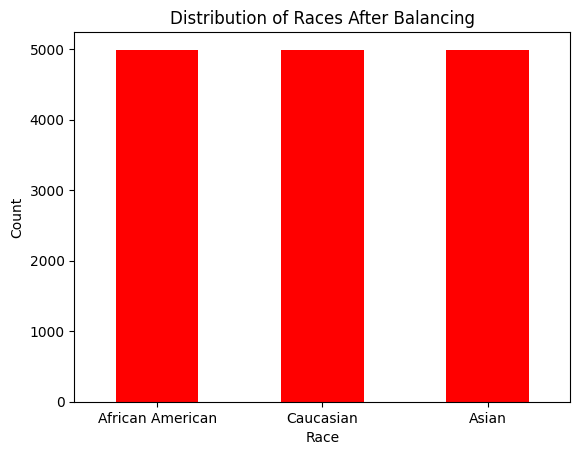

In [ ]:
audio_df.race.value_counts().plot(kind='bar', color='red')
plt.xticks(rotation=0)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Races After Balancing')
plt.savefig('Race_distribution_post.png')

In [ ]:
audio_df

,emotion,actor,path,race
0,ANG,1001,CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav,Caucasian
1,DIS,1001,CREMA-D/AudioWAV/1001_DFA_DIS_XX.wav,Caucasian
2,FEA,1001,CREMA-D/AudioWAV/1001_DFA_FEA_XX.wav,Caucasian
3,HAP,1001,CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav,Caucasian
4,NEU,1001,CREMA-D/AudioWAV/1001_DFA_NEU_XX.wav,Caucasian
...,...,...,...,...
14961,SAD,1091,CREMA-D/AudioWAV/1091_WSI_SAD_XX_3464.wav,Asian
14962,SAD,1091,CREMA-D/AudioWAV/1091_WSI_SAD_XX_3555.wav,Asian
14963,SAD,1091,CREMA-D/AudioWAV/1091_WSI_SAD_XX_394.wav,Asian
14964,SAD,1091,CREMA-D/AudioWAV/1091_WSI_SAD_XX_587.wav,Asian




---



# Feature Extraction

In [ ]:
# FOR WHOLE DATAFRAME

# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
def mel_spectrogram(dataframe):
  df = pd.DataFrame(columns=['mel_spectrogram'])
  counter = 0
  for index,path in enumerate(dataframe.path):
      X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

      #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
      spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
      db_spec = librosa.power_to_db(spectrogram)
      #temporally average spectrogram
      log_spectrogram = np.mean(db_spec, axis = 0)

      # Mel-frequency cepstral coefficients (MFCCs)
  #     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  #     mfcc=np.mean(mfcc,axis=0)

      # compute chroma energy (pertains to 12 different pitch classes)
  #     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
  #     chroma = np.mean(chroma, axis = 0)

      # compute spectral contrast
  #     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
  #     contrast = np.mean(contrast, axis= 0)

      # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at
  #     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
  #     zcr = librosa.feature.zero_crossing_rate(y=X)
  #     zcr = np.mean(zcr, axis= 0)

      df.loc[counter] = [log_spectrogram]
      counter=counter+1
  return df

In [ ]:
# FOR A SINGLE AUDIO FILE

# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
def mel_spectrogram(audio_file):
  X, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
  #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
  spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
  db_spec = librosa.power_to_db(spectrogram)
   #temporally average spectrogram
  log_spectrogram = np.mean(db_spec, axis = 0)

  return log_spectrogram

In [ ]:
mel_spectrogram('CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav')

In [ ]:
df = mel_spectrogram(audio_df)
print(len(df))
df.head()

7442


,mel_spectrogram
0,"[-8.611901, -8.497661, -11.3269615, -12.500107..."
1,"[-43.943283, -42.09897, -38.89283, -26.912682,..."
2,"[-42.535862, -40.42614, -39.694233, -40.159477..."
3,"[-23.501884, -19.445797, -18.871653, -18.38984..."
4,"[-25.88915, -24.836338, -27.5353, -29.413418, ..."


In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [ ]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [ ]:
# CHECK TOP 5 ROWS
df_combined

,emotion,actor,race,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,ANG,1001,Caucasian,-8.611901,-8.497661,-11.326962,-12.500107,-14.003399,-15.888887,-18.942160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DIS,1001,Caucasian,-43.943283,-42.098969,-38.892830,-26.912682,-21.941996,-18.847887,-15.480346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FEA,1001,Caucasian,-42.535862,-40.426140,-39.694233,-40.159477,-41.028137,-37.574142,-25.677588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HAP,1001,Caucasian,-23.501884,-19.445797,-18.871653,-18.389839,-17.496157,-18.229759,-20.004917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NEU,1001,Caucasian,-25.889151,-24.836338,-27.535299,-29.413418,-30.384449,-32.063469,-31.157967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,DIS,1091,Asian,-31.066071,-27.385847,-27.083515,-26.965708,-28.094191,-28.400219,-26.585581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7438,FEA,1091,Asian,-45.539360,-44.730701,-45.265045,-45.047626,-44.548897,-45.111446,-45.482693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7439,HAP,1091,Asian,-44.267765,-41.826614,-40.189045,-40.959946,-41.186031,-39.452324,-39.235657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7440,NEU,1091,Asian,-46.397556,-44.454445,-44.671852,-44.768036,-43.123863,-37.610832,-33.707790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prepping Data for Modeling

In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','race','actor']])

In [ ]:
train

,emotion,actor,race,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
2394,DIS,1030,African American,-43.743977,-41.844650,-41.525620,-41.289944,-40.819611,-41.143673,-41.438435,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1040,SAD,1013,Caucasian,-40.158867,-40.584538,-41.667347,-40.157532,-36.392365,-34.184967,-33.495312,...,-41.499298,-41.086800,-42.009808,-41.262829,-41.574512,-42.126160,-42.174534,-42.604073,-42.108822,-42.478832
3649,FEA,1045,Asian,-40.717083,-39.703953,-41.316967,-42.122772,-41.019623,-40.759678,-40.698334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4619,ANG,1057,Caucasian,-7.147901,-9.049105,-14.135948,-15.185013,-17.449249,-19.492907,-20.830181,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1274,SAD,1016,Caucasian,-36.758739,-38.743828,-39.789139,-40.084980,-39.710697,-39.616062,-38.963005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,DIS,1003,Caucasian,-35.848083,-29.825863,-26.753052,-24.710024,-22.994101,-22.546635,-22.559912,...,-42.094288,-42.239182,-42.623432,-42.109219,-41.951458,-42.127098,-42.490505,-42.405151,-42.422058,-43.113750
1265,FEA,1016,Caucasian,-43.730370,-42.248268,-42.062202,-41.686417,-41.284195,-40.747292,-40.590385,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4679,FEA,1058,Caucasian,-26.200586,-28.167290,-30.190941,-28.984150,-26.546108,-24.760300,-23.108271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1462,SAD,1018,Caucasian,-33.473743,-34.816639,-37.704533,-37.385571,-36.839146,-35.518696,-34.120842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:1] #y_train = train.iloc[:,:2].drop(columns=['gender']) así es como es en el código original
X_test = train.iloc[:, 3:]
y_test = train.iloc[:,:1]
print(X_train.shape)
X_train

(5953, 259)


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
2394,-43.743977,-41.844650,-41.525620,-41.289944,-40.819611,-41.143673,-41.438435,-41.914852,-41.409012,-40.879223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1040,-40.158867,-40.584538,-41.667347,-40.157532,-36.392365,-34.184967,-33.495312,-33.816601,-33.305687,-32.566780,...,-41.499298,-41.086800,-42.009808,-41.262829,-41.574512,-42.126160,-42.174534,-42.604073,-42.108822,-42.478832
3649,-40.717083,-39.703953,-41.316967,-42.122772,-41.019623,-40.759678,-40.698334,-41.181709,-41.839840,-40.906864,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4619,-7.147901,-9.049105,-14.135948,-15.185013,-17.449249,-19.492907,-20.830181,-21.692492,-20.838181,-19.175941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1274,-36.758739,-38.743828,-39.789139,-40.084980,-39.710697,-39.616062,-38.963005,-39.735516,-40.412586,-40.612579,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,-35.848083,-29.825863,-26.753052,-24.710024,-22.994101,-22.546635,-22.559912,-22.643463,-21.273600,-19.962664,...,-42.094288,-42.239182,-42.623432,-42.109219,-41.951458,-42.127098,-42.490505,-42.405151,-42.422058,-43.113750
1265,-43.730370,-42.248268,-42.062202,-41.686417,-41.284195,-40.747292,-40.590385,-40.643883,-40.778084,-41.586098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4679,-26.200586,-28.167290,-30.190941,-28.984150,-26.546108,-24.760300,-23.108271,-22.948421,-22.987341,-22.405596,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1462,-33.473743,-34.816639,-37.704533,-37.385571,-36.839146,-35.518696,-34.120842,-33.604897,-31.926466,-30.710197,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Data Preprocessing

In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
2394,-1.023558,-1.007548,-0.976278,-0.966299,-0.954906,-0.999276,-1.061664,-1.116267,-1.102173,-1.061470,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
1040,-0.696127,-0.887927,-0.990161,-0.856285,-0.526143,-0.329715,-0.297262,-0.341103,-0.322274,-0.260101,...,-4.012127,-3.920911,-4.248504,-4.169182,-4.441702,-4.522041,-4.490875,-4.777243,-4.720419,-4.752607
3649,-0.747109,-0.804335,-0.955839,-1.047209,-0.974277,-0.962328,-0.990441,-1.046090,-1.143637,-1.064134,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
4619,2.318790,2.105682,1.706712,1.569812,1.308430,1.083943,0.921558,0.819415,0.877652,1.030855,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
1274,-0.385591,-0.713191,-0.806179,-0.849236,-0.847512,-0.852291,-0.823442,-0.907661,-1.006272,-1.035764,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,-0.302420,0.133377,0.470788,0.644451,0.771431,0.790116,0.755099,0.728388,0.835745,0.955010,...,-4.073344,-4.038098,-4.314166,-4.259765,-4.484088,-4.522147,-4.526265,-4.753895,-4.757194,-4.826977
1265,-1.022315,-1.045862,-1.028840,-1.004817,-0.999899,-0.961137,-0.980052,-0.994610,-1.041449,-1.129617,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
4679,0.578693,0.290823,0.134025,0.229217,0.427432,0.577119,0.702328,0.699197,0.670808,0.719497,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079
1462,-0.085570,-0.340389,-0.601979,-0.586987,-0.569412,-0.458045,-0.357460,-0.320839,-0.189532,-0.081116,...,0.257615,0.257264,0.246836,0.246844,0.233137,0.233001,0.232859,0.223460,0.223337,0.223079


In [ ]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
#y_train = np.ravel(y_train)
#y_test = np.ravel(y_test)
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
print(lb.classes_)

['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
labels=['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

## Dummy Classifiers

In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)


0.06685704686712582

In [ ]:
x_test111t=X_test111
x_test111t=x_test111t[:,:,0]
x_test111t.shape

(1, 259)

In [ ]:
from sklearn import tree
#x_test111t=X_test111
#x_test111t=x_test111t[:,:,0]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
#print(clf.predict(x_test))
clf.score(X_test, y_test)


0.9993280698807324

## Initial Model

In [ ]:
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
X_train2=X_train[1,:,:]
X_train2=X_train2[np.newaxis,:,:]
X_train2.shape

(1, 259, 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
def cnn_model(X_train, optimizer):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(6, activation='softmax'))  #I changed '8' by '6' bc in our project we have 6 classes not 8
  if optimizer=='Adam': opt = keras.optimizers.Adam(learning_rate=0.001)
  elif optimizer=='SGD': opt = keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  model.summary()
  return model

model = cnn_model(X_train,'SGD')
#opt = keras.optimizers.Adam(learning_rate=0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                    

In [ ]:
#prev params (baseline):
#{'batch_size': 32, 'nb_epoch': 40, 'optimizer': 'SGD'}

#best params after grid search:
#{'batch_size': 36, 'nb_epoch': 75, 'optimizer': 'SGD'}

In [ ]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

##
checkpoint1_path = 'cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint1_path,
                                                 save_weights_only=True,
                                                 verbose=1)

##

model_history=model.fit(X_train, y_train, batch_size=36, epochs=100, validation_data=(X_test, y_test), callbacks=[cp_callback])

Epoch 1/100
166/166 [==============================] - ETA: 0s - loss: 2.6597 - accuracy: 0.1730
Epoch 1: saving model to cp.ckpt
166/166 [==============================] - 33s 190ms/step - loss: 2.6597 - accuracy: 0.1730 - val_loss: 2.6267 - val_accuracy: 0.2503
Epoch 2/100
166/166 [==============================] - ETA: 0s - loss: 2.6366 - accuracy: 0.1903
Epoch 2: saving model to cp.ckpt
166/166 [==============================] - 36s 218ms/step - loss: 2.6366 - accuracy: 0.1903 - val_loss: 2.6062 - val_accuracy: 0.2928
Epoch 3/100
166/166 [==============================] - ETA: 0s - loss: 2.6169 - accuracy: 0.2125
Epoch 3: saving model to cp.ckpt
166/166 [==============================] - 36s 216ms/step - loss: 2.6169 - accuracy: 0.2125 - val_loss: 2.5866 - val_accuracy: 0.3175
Epoch 4/100
166/166 [==============================] - ETA: 0s - loss: 2.5930 - accuracy: 0.2343
Epoch 4: saving model to cp.ckpt
166/166 [==============================] - 36s 217ms/step - loss: 2.5930 - acc

In [ ]:
#to use the checkpoint add the corresponding files to the main folder
checkpoint_dir = os.path.dirname(checkpoint1_path)
os.listdir(checkpoint_dir)

FileNotFoundError: [Errno 2] No such file or directory: ''

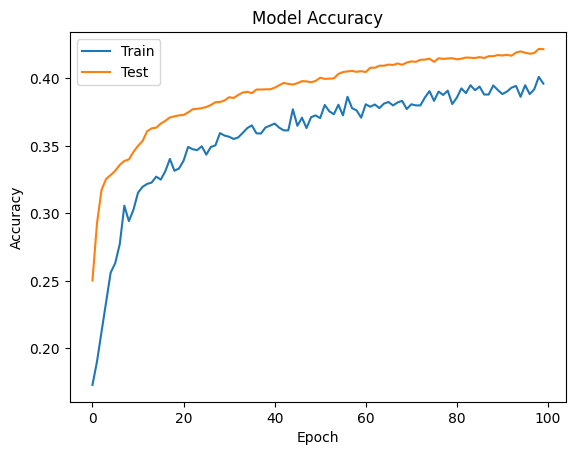

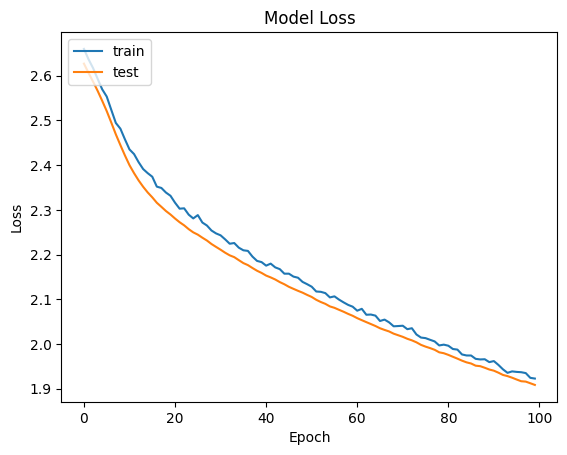

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

print(X_test.shape)
# PREDICTIONS
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
#lb = LabelEncoder()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[0:10]

187/187 [==============================] - 6s 29ms/step - loss: 1.9085 - accuracy: 0.4216
Loss of the model is -  1.908496379852295
187/187 [==============================] - 6s 30ms/step - loss: 1.9085 - accuracy: 0.4216
Accuracy of the model is -  42.1636164188385 %
(5953, 259, 1)
187/187 [==============================] - 7s 38ms/step


,Actual Values,Predicted Values
0,DIS,DIS
1,SAD,SAD
2,FEA,SAD
3,ANG,ANG
4,SAD,DIS
5,FEA,NEU
6,DIS,DIS
7,NEU,NEU
8,ANG,ANG
9,NEU,SAD


In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,0.760150,0.774447,0.786577,0.821489,0.817987,0.749658,0.697741,0.745376,0.762774,0.791600,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
1,-0.870570,-0.867432,-0.889683,-0.878152,-0.904634,-0.999997,-1.126443,-1.074997,-1.085011,-1.098967,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
2,-0.507906,-0.361217,-0.215926,-0.145285,-0.065479,-0.050784,-0.089120,-0.059328,-0.084815,-0.155336,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
3,-1.184772,-1.194844,-1.164607,-1.211194,-1.317495,-1.347166,-1.343282,-1.362453,-1.398215,-1.404189,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
4,0.889032,0.869450,0.826534,0.822345,0.827207,0.815563,0.746328,0.781049,0.757310,0.714930,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11966,0.597001,0.238317,-0.121363,-0.188401,-0.373234,-0.656685,-0.777541,-0.918536,-1.109205,-1.191487,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
11967,1.257263,1.206303,1.187806,1.130725,1.127965,1.064433,0.993564,0.883377,0.800771,0.806931,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
11968,0.077258,-0.108186,-0.170445,-0.228614,-0.280094,-0.275095,0.117179,0.467500,0.609902,0.674864,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965
11969,-1.281900,-1.467711,-1.546997,-1.587282,-1.630513,-1.641779,-1.610965,-1.648398,-1.679587,-1.680264,...,0.213331,0.213473,0.204804,0.204828,0.192365,0.192277,0.192208,0.183147,0.183088,0.186965


# **HRI (testing)**

## DATA

In [ ]:
#FOR A SINGLE AUDIO FILE  :)
print(type(X_test))
print(X_test.shape)

#TEST1
X_test1 = np.expand_dims(X_test[0], axis=0)
y_test1 = np.expand_dims(y_test[0], axis=0)

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
%print("Loss of the model is - " , model.evaluate(X_test1,y_test1)[0])
%print("Accuracy of the model is - " , model.evaluate(X_test1,y_test1)[1]*100 , "%")

# PREDICTIONS
predictions = model.predict(X_test1)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()

predictions = (lb.inverse_transform((predictions)))
str(predictions[0])
(X_test1.shape)


## MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
#BUILD 1D CNN LAYERS
def cnn_model(X_train, optimizer):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(8)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(6, activation='softmax'))  #I changed '8' by '6' bc in our project we have 6 classes not 8
  if optimizer=='Adam': opt = keras.optimizers.Adam(learning_rate=0.001)
  elif optimizer=='SGD': opt = keras.optimizers.SGD(learning_rate=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  model.summary()
  return model

model = cnn_model(X_test111,'SGD')

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_109 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_110 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_108 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_111 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                

## PREDICTION

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")


46/46 [==============================] - 2s 32ms/step - loss: 2.6418 - accuracy: 0.1855
Loss of the model is -  2.6418204307556152
46/46 [==============================] - 1s 22ms/step - loss: 2.6418 - accuracy: 0.1855
Accuracy of the model is -  18.546195328235626 %


In [ ]:
#HRI
#TO LOAD THE MODEL

#Only weights are saved so we need to define the same architecture to be able to use them
#In this case:
#model = cnn_model(X_train,'SGD')

#Loading weights:
checkpoint1_path = 'cp.ckpt'
model.load_weights(checkpoint1_path)

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

# PREDICTIONS
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
#lb = LabelEncoder()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
#actual = y_test.argmax(axis=1)
#actual = actual.astype(int).flatten()
#actual = (lb.inverse_transform((actual)))
#actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
#finaldf = actual.join(predictions)
#finaldf[0:10]

# **HRI FINAL**

In [ ]:
%%capture
#RESTART SESSION AFTER INSTALLING NEW PACKAGES!!!
!pip install resampy

#Do in case not working:
#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0
#!pip install keras==2.12.0

In [ ]:
import librosa
import resampy
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

In [ ]:
#%%writefile emotion.py
#!usr/bin/bash python

labels=['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

features=True
train=False
load=True
predict=True
tree=False

audio_file='ang2.wav'

def mel_spectrogram(audio_file):
  X, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
  #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
  spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
  db_spec = librosa.power_to_db(spectrogram)
   #temporally average spectrogram
  log_spectrogram = np.mean(db_spec, axis = 0)
  return log_spectrogram

if features:
  mel_spec_audio=mel_spectrogram(audio_file)
  X_test111 = mel_spec_audio
  n1=259-X_test111.shape[0] #259 being the input shape of the trained model
  n=n1//2
  X_test111=np.pad(X_test111, n, 'constant') #padding the number of mfccs missing
  mean = np.mean(X_test111, axis=0) #normalizing
  std = np.std(X_test111, axis=0)
  X_test111 = (X_test111 - mean)/std
  X_test111=X_test111[np.newaxis,:,np.newaxis] #adding missing dimentions

#ADD X_TRAIN AND Y_TRAIN
#if train:
 # with open(audio_file) as audio_file:
  #  checkpoint_path = 'cp.ckpt'
   # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
    #model_history=model.fit(X_train, y_train, batch_size=36, epochs=100, validation_data=(X_test, y_test), callbacks=[cp_callback])

if load:
  def cnn_model(X_train, optimizer):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(6, activation='softmax'))
    if optimizer=='Adam': opt = keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer=='SGD': opt = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model

  model = cnn_model(X_test111,'SGD')

  #loading model weights from checkpoint
  checkpoint_path = 'cp.ckpt'
  model.load_weights(checkpoint_path)

if predict:
  predictions = model.predict(X_test111)
  #second highest:
  predictions2 = np.sort(predictions)
  predictions2 = np.argsort(predictions[0])[::-1][:2]
  pred_label1 = predictions2[0]
  pred_label2 = predictions2[1]
  pred_val1 = predictions[0][predictions2][0]*100
  pred_val2 = predictions[0][predictions2][1]*100
  print(str(labels[pred_label1])+' '+str(round(pred_val1,2))+'%')
  print(str(labels[pred_label2])+' '+str(round(pred_val2,2))+'%')

#NEEDS X_TRAIN AND Y_TRAIN
if tree:
  from sklearn import tree
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
  x_test111t=X_test111
  x_test111t=x_test111t[:,:,0]
  predictions1 = clf.predict(x_test111t)
  predictions1 = predictions1.argmax(axis=1)
  predictions1 = predictions1.astype(int).flatten()
  pred_label1 = predictions1[0]
  print(labels[pred_label1])
  print(clf.score(X_test, y_test))

#!python3 emotion.py 'CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav' False False True

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_180 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_181 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_120 (MaxPool  (None, 30, 128)           0         
 ing1D)                                                          
                                                                 
 dropout_180 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_182 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_121 (MaxPool  (None, 2, 128)            0         
 ing1D)                                              



---



---



In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']))

              precision    recall  f1-score   support

         ANG       0.57      0.74      0.64       518
         DIS       0.29      0.24      0.26       521
         FEA       0.18      0.00      0.01       516
         HAP       0.42      0.35      0.38       511
         NEU       0.34      0.16      0.21       418
         SAD       0.33      0.81      0.46       509

    accuracy                           0.39      2993
   macro avg       0.35      0.38      0.33      2993
weighted avg       0.35      0.39      0.33      2993



# Hyperparameter Tuning

In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['race','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:1]#.drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:1]#.drop(columns=['gender'])
print(X_test.shape)

(11972, 259)
(2993, 259)


In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
opt = keras.optimizers.Adam(learning_rate=0.0001)
def make_classifier(optimizer=opt):
    #BUILD CNN MODEL
    print(X_train.shape)
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(6, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


In [ ]:
y_trainHot=np.argmax(y_train, axis=1)

In [ ]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 36, 42],  #I changed [30, 32, 34] by [30, 36, 42] so that they are multiple of 6 (num_classes)
    'nb_epoch': [25, 50, 75, 100],  #I added 100
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_trainHot)

(11972, 259, 1)
75/75 [==============================] - 2s 30ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 3s 41ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 4s 46ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 5s 61ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/75 [==============================] - 4s 49ms/step
(11972, 259, 1)
75/75 [==============================] - 2s 29ms/step
(11972, 259, 1)
75/7

In [ ]:
grid_search.best_params_

{'batch_size': 30, 'nb_epoch': 100, 'optimizer': 'SGD'}

In [ ]:
grid_search.best_score_

0.28006753138936413